In [1]:
!pip install opendatasets --upgrade --quiet

In [2]:
import opendatasets as od

dataset_url = 'https://www.kaggle.com/jutrera/stanford-car-dataset-by-classes-folder'
od.download(dataset_url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: stefanoramponi
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/jutrera/stanford-car-dataset-by-classes-folder


100%|██████████| 1.83G/1.83G [01:37<00:00, 20.2MB/s]


In [3]:
from torch.utils.data import Dataset
import os

DATA_DIR_TRAIN = './stanford-car-dataset-by-classes-folder/car_data/car_data/train'
train_classes = os.listdir(DATA_DIR_TRAIN)

DATA_DIR_TEST = './stanford-car-dataset-by-classes-folder/car_data/car_data/test'
test_classes = os.listdir(DATA_DIR_TEST)

In [4]:
def find_classes(dir):
    train_classes = os.listdir(dir)
    train_classes.sort()
    train_class_to_idx = {train_classes[i]: i for i in range(len(train_classes))}
    return train_classes, train_class_to_idx
    test_class_to_idx = {test_classes[i]: i for i in range(len(test_classes))}
    return test_classes, test_class_to_idx

train_classes, train_c_to_idx = find_classes(DATA_DIR_TRAIN)
test_classes, test_c_to_idx = find_classes(DATA_DIR_TEST)

train_classes[:5], test_classes[:5]

(['AM General Hummer SUV 2000',
  'Acura Integra Type R 2001',
  'Acura RL Sedan 2012',
  'Acura TL Sedan 2012',
  'Acura TL Type-S 2008'],
 ['AM General Hummer SUV 2000',
  'Acura Integra Type R 2001',
  'Acura RL Sedan 2012',
  'Acura TL Sedan 2012',
  'Acura TL Type-S 2008'])

In [5]:
def find_classes(dir):
    test_classes = os.listdir(dir)
    test_classes.sort()
    test_class_to_idx = {test_classes[i]: i for i in range(len(test_classes))}
    return test_classes, test_class_to_idx
test_classes, test_c_to_idx = find_classes(DATA_DIR_TEST)

In [6]:
def extract_class(Datasets):
  for vals in os.listdir(Datasets):
    print(vals)

In [7]:
extract_class(DATA_DIR_TRAIN)


Audi TT Hatchback 2011
Rolls-Royce Ghost Sedan 2012
Buick Verano Sedan 2012
Bentley Continental Supersports Conv. Convertible 2012
BMW M5 Sedan 2010
Suzuki Kizashi Sedan 2012
Ford GT Coupe 2006
Hyundai Elantra Touring Hatchback 2012
Toyota Corolla Sedan 2012
BMW M3 Coupe 2012
Mercedes-Benz E-Class Sedan 2012
Audi S6 Sedan 2011
FIAT 500 Convertible 2012
Ram C-V Cargo Van Minivan 2012
Audi 100 Sedan 1994
Volkswagen Beetle Hatchback 2012
Nissan Leaf Hatchback 2012
Rolls-Royce Phantom Sedan 2012
BMW 3 Series Wagon 2012
smart fortwo Convertible 2012
Chevrolet Impala Sedan 2007
Ford F-150 Regular Cab 2012
Mercedes-Benz C-Class Sedan 2012
Mazda Tribute SUV 2011
Chrysler Crossfire Convertible 2008
Chevrolet Corvette Ron Fellows Edition Z06 2007
Volkswagen Golf Hatchback 2012
Lamborghini Gallardo LP 570-4 Superleggera 2012
Dodge Magnum Wagon 2008
Ford Edge SUV 2012
Chevrolet Silverado 1500 Classic Extended Cab 2007
Lamborghini Diablo Coupe 2001
Audi V8 Sedan 1994
BMW X3 SUV 2012
Acura TSX Sedan

In [8]:
import os
import torch
import torchvision
import tarfile
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from torch.utils.data import random_split
from torchvision.utils import make_grid
from torchvision.transforms import ToTensor
train_dataset = ImageFolder(DATA_DIR_TRAIN, transform = ToTensor())
test_dataset = ImageFolder(DATA_DIR_TEST, transform = ToTensor())

Label:  AM General Hummer SUV 2000 (0)


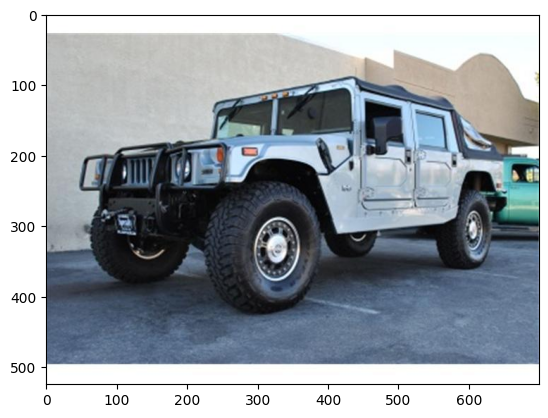

In [9]:
import matplotlib
import matplotlib.pyplot as plt
def show_example(img, label):
    print('Label: ', train_dataset.classes[label], "("+str(label)+")")
    plt.imshow(img.permute(1, 2, 0))

show_example(*train_dataset[0])

In [10]:
train_tfms = tt.Compose([tt.Resize((256, 256)),
                         tt.RandomRotation(0),
                         tt.ToTensor(),
                         tt.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
test_tfms = tt.Compose([tt.Resize((256, 256)),
                        tt.ToTensor(),
                        tt.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
train_dataset = ImageFolder(DATA_DIR_TRAIN, transform = train_tfms)
test_dataset = ImageFolder(DATA_DIR_TEST, transform = test_tfms)

In [11]:
random_seed = 42
torch.manual_seed(random_seed);
val_percent = 0.1
val_size = int(val_percent * len(train_dataset))
train_size = len(train_dataset) - val_size

train_ds, val_ds = random_split(train_dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(7330, 814)

In [12]:
batch_size = 128
train_dl = DataLoader(train_ds, batch_size, shuffle = True, num_workers = 4, pin_memory = True)
val_dl = DataLoader(val_ds, batch_size * 2, num_workers = 4, pin_memory=True)


# Model

In [13]:
simple_model = nn.Sequential(
    nn.Conv2d(3,8, kernel_size = 3, stride = 1, padding = 1),
    nn.MaxPool2d(2,2)
)

In [14]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [15]:
class StanfordCarsModel(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 8, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 16 x 128 x 128

            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 32 x 64 x 64

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 64 x 32 x 32

            nn.Flatten(),
            nn.Linear(64*32*32, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 196))

    def forward(self, xb):
        return self.network(xb)

model = StanfordCarsModel()
model

StanfordCarsModel(
  (network): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=65536, out_features=1024, bias=True)
    (17): ReLU()
    (18): Linear(in_features=1

In [16]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [17]:
device = get_default_device()
device

device(type='cuda')

In [18]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
to_device(model, device);

# Train the model

In [19]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [20]:
model = to_device(StanfordCarsModel(), device)
evaluate(model, val_dl)

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


{'val_loss': 5.277237892150879, 'val_acc': 0.009341033175587654}

In [21]:
num_epochs = 10
opt_func = torch.optim.Adam
lr = 5e-2

In [22]:
history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

Epoch [0], train_loss: 12051.4932, val_loss: 5.2939, val_acc: 0.0226
Epoch [1], train_loss: 5.2936, val_loss: 5.2905, val_acc: 0.0226
Epoch [2], train_loss: 5.2932, val_loss: 5.2888, val_acc: 0.0226
Epoch [3], train_loss: 5.2926, val_loss: 5.2918, val_acc: 0.0226
Epoch [4], train_loss: 5.2912, val_loss: 5.2909, val_acc: 0.0226
Epoch [5], train_loss: 5.2921, val_loss: 5.2973, val_acc: 0.0226
Epoch [6], train_loss: 5.2936, val_loss: 5.2911, val_acc: 0.0226
Epoch [7], train_loss: 5.2928, val_loss: 5.2946, val_acc: 0.0226
Epoch [8], train_loss: 5.2927, val_loss: 5.2892, val_acc: 0.0226
Epoch [9], train_loss: 5.2915, val_loss: 5.2981, val_acc: 0.0020


In [24]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return test_dataset.classes[preds[0].item()]

Label: Lamborghini Diablo Coupe 2001 , Predicted: Jeep Liberty SUV 2012


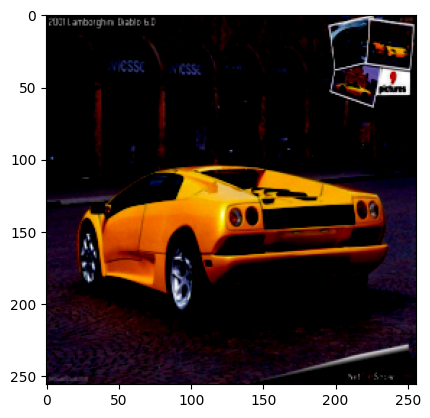

In [25]:
img, label = test_dataset[6153]
plt.imshow(img.permute(1, 2, 0))
print('Label:', test_dataset.classes[label], ', Predicted:', predict_image(img, model))

In [26]:
from torchvision import models

class StanfordCarsModel(ImageClassificationBase):
    def __init__(self, num_classes, pretrained=True):
        super().__init__()
        # Use a pretrained model
        self.network = models.resnet34(pretrained=pretrained)
        # Replace last layer
        self.network.fc = nn.Linear(self.network.fc.in_features, num_classes)

    def forward(self, xb):
        return self.network(xb)

In [27]:
import torch
from tqdm.notebook import tqdm

@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)


def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader,
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []

    # Set up custom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs,
                                                steps_per_epoch=len(train_loader))

    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        lrs = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()

            # Gradient clipping
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)

            optimizer.step()
            optimizer.zero_grad()

            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()

        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [28]:
model = StanfordCarsModel(len(train_dataset.classes))
to_device(model, device);

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:01<00:00, 62.9MB/s]


In [29]:
model

StanfordCarsModel(
  (network): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True,

In [32]:
epochs = 12
max_lr = 0.0001
grad_clip = 0.1
weight_decay = 1e-4

opt_func = torch.optim.Adam

In [33]:
history = fit_one_cycle(epochs, max_lr, model, train_dl, val_dl,
                         grad_clip=grad_clip,
                         weight_decay=weight_decay,
                         opt_func=opt_func)

  0%|          | 0/58 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch [0], train_loss: 5.4618, val_loss: 5.3114, val_acc: 0.0068


  0%|          | 0/58 [00:00<?, ?it/s]

Epoch [1], train_loss: 4.9364, val_loss: 4.5836, val_acc: 0.1028


  0%|          | 0/58 [00:00<?, ?it/s]

Epoch [2], train_loss: 3.9045, val_loss: 3.5640, val_acc: 0.3335


  0%|          | 0/58 [00:00<?, ?it/s]

Epoch [3], train_loss: 2.6406, val_loss: 2.7257, val_acc: 0.5151


  0%|          | 0/58 [00:00<?, ?it/s]

Epoch [4], train_loss: 1.4396, val_loss: 2.2278, val_acc: 0.6090


  0%|          | 0/58 [00:00<?, ?it/s]

Epoch [5], train_loss: 0.6410, val_loss: 1.8457, val_acc: 0.6957


  0%|          | 0/58 [00:00<?, ?it/s]

Epoch [6], train_loss: 0.2717, val_loss: 1.6725, val_acc: 0.7172


  0%|          | 0/58 [00:00<?, ?it/s]

Epoch [7], train_loss: 0.1482, val_loss: 1.6213, val_acc: 0.7119


  0%|          | 0/58 [00:00<?, ?it/s]

Epoch [8], train_loss: 0.1059, val_loss: 1.5864, val_acc: 0.7265


  0%|          | 0/58 [00:00<?, ?it/s]

Epoch [9], train_loss: 0.0877, val_loss: 1.5687, val_acc: 0.7261


  0%|          | 0/58 [00:00<?, ?it/s]

Epoch [10], train_loss: 0.0818, val_loss: 1.5701, val_acc: 0.7290


  0%|          | 0/58 [00:00<?, ?it/s]

Epoch [11], train_loss: 0.0785, val_loss: 1.5707, val_acc: 0.7280


Label: AM General Hummer SUV 2000 , Predicted: AM General Hummer SUV 2000


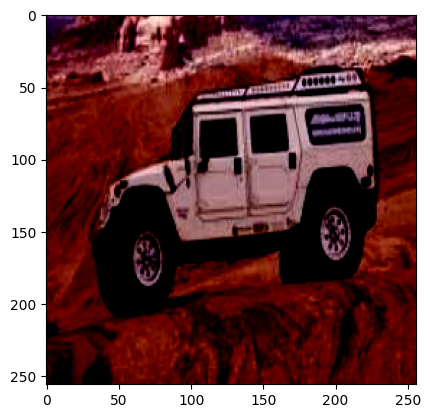

In [34]:
img, label = test_dataset[1]
plt.imshow(img.permute(1, 2, 0))
print('Label:', test_dataset.classes[label], ', Predicted:', predict_image(img, model))

In [35]:
torch.save(model.state_dict(), 'stanfordcars-cnn.pth')

In [36]:
model2 = to_device(StanfordCarsModel(len(train_dataset.classes)), device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [37]:
model2.load_state_dict(torch.load('stanfordcars-cnn.pth'))

<All keys matched successfully>